# LL parsing (optional)

Deterministic PDAs are appealing because they are much easier to implement. However, the CFG to PDA conversion in the book outputs a deterministic PDA only for the most uninteresting CFGs.

For example, the following grammar generates the language $\{\texttt{a}^i \texttt{b}^j \texttt{c}^i \mid i, j \geq 0\}$, which you could easily write a deterministic PDA for:

\begin{align*}
S &\rightarrow \texttt{a} S \texttt{c} \\
S &\rightarrow T \\
T &\rightarrow \texttt{b} T \\
T &\rightarrow \varepsilon
\end{align*}

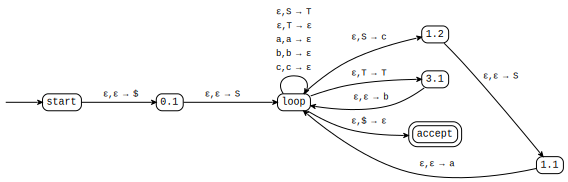

In [1]:
from tock import *

g = Grammar.from_lines(["S -> a S c",
                        "S -> T",
                        "T -> b T",
                        "T -> &"])
p1 = from_grammar(g)
to_graph(p1)

In [2]:
p1.is_deterministic()

False

There is nondeterminism in state `loop`, when the top stack symbol is either $S$ or $T$. Each of these nonterminals has two rules it can be rewritten with, and the PDA doesn't know which one to use. You can figure it out intuitively:

- If the top stack symbol is $S$:
    - If the next input symbol is $\texttt{a}$, use the first rule.
    - Else, use the second rule.
- If the top stack symbol is $T$:
    - If the next symbol is $\texttt{b}$, use the third rule.
    - Else, use the fourth rule.
    
Below, we'll show how to modify the CFG to PDA conversion to output a deterministic PDA that is able to _look ahead_ one symbol to capture the above intuition.

## The endmarker

When the PDA is at the end of the string, we want it to be able to look ahead and see that there are no more input symbols. So let's append an _endmarker_ $\dashv$ to end of the input string. We continue to write $\Sigma$ for the original alphabet that does not contain $\dashv$.

Accordingly, we modify our grammar by creating a new start nonterminal, $S'$, and adding a rule

$$ S' \rightarrow S\dashv $$

## Basic idea

Given a top stack symbol $A$ and a look-ahead input symbol $c$, we want to automatically figure out which rule $A \rightarrow \beta$ to use. The logic will go as follows:

- If $\beta$ can be rewritten to a string that starts with $c$, then $A \rightarrow \beta$ is possible.
- If $\beta$ can be rewritten to $\varepsilon$ and it's possible for $c$ to come after $A$, then $A \rightarrow \beta$ is possible.

And we only want one rule to be possible at a time.

We implement this logic by precomputing three tables, defined below.

## The $\text{Nullable}$ table

Define a _rhs suffix_ of $G$ to be a suffix of the right-hand side of a rule of $G$. The rhs suffixes of our example grammar are: $\varepsilon, \texttt{c}, S\texttt{c}, \texttt{a}S\texttt{c}, T, \texttt{b}T$.

Define a table $\text{Nullable}(\alpha)$, where $\alpha$ is a terminal or nonterminal symbol or a rhs suffix, that says whether it's possible to rewrite $\alpha$ to the empty string (that is, $\alpha \Rightarrow^\ast \varepsilon$).

1. For all $\alpha$, $\text{Nullable}(\alpha) \leftarrow \text{False}$.
2. $\text{Nullable}(\epsilon) \leftarrow \text{True}$.
3. Repeat until $\text{Nullable}$ does not change:
    1. For each rule $A \rightarrow \beta$:
        1. $n \leftarrow |\beta|$
        2. For $i \leftarrow n, \ldots, 1$:
            1. If $\text{Nullable}(\beta_{i+1} \cdots \beta_n)$ and $\text{Nullable}(\beta_i)$, then $\text{Nullable}(\beta_i \cdots \beta_n) \leftarrow \text{True}$
        3. If $\text{Nullable}(\beta)$, then $\text{Nullable}(A) \leftarrow \text{True}$.

In our example grammar, $S$ and $T$ are both nullable, but $S'$ is not. The nullable rhs suffixes are: $\varepsilon, T$.

## The $\text{First}$ table

Define a table $\text{First}(\alpha)$, where $\alpha$ is a terminal or nonterminal symbol
or a rhs suffix, that says what terminals $\alpha$ can start with (after rewriting). That is, 
$$\text{First}(\alpha) = \{b \mid \text{$\alpha \Rightarrow^\ast b\gamma$ for some $\gamma$}\}$$

1. For all $\alpha$, $\text{First}(\alpha) = \emptyset$.
1. For all terminals $a$, $\text{First}(a) = \{ a \}$.
2. Repeat until $\text{First}$ does not change:
    1. For each rule $A \rightarrow \beta$:
        1. $n \leftarrow |\beta|$
        2. For $i \leftarrow n, \ldots, 1$:
            1. $\text{First}(\beta_i \cdots \beta_n) \leftarrow \text{First}(\beta_i \cdots \beta_n) \cup \text{First}(\beta_{i})$.
            1. If $\text{Nullable}(\beta_i)$, then $\text{First}(\beta_i \cdots \beta_n) \leftarrow \text{First}(\beta_i \cdots \beta_n) \cup \text{First}(\beta_{i+1} \cdots \beta_n)$.
        3. $\text{First}(A) \leftarrow \text{First}(A) \cup \text{First}(\beta)$.

In our example grammar, we have

| $\alpha$ | $\text{First}(\alpha)$ |
|----------|------------------------|
| $S$      | $\{\texttt{a}, \texttt{b}\}$ |
| $T$      | $\{\texttt{b}\}$ |
| $\texttt{a}$ | $\{\texttt{a}\}$ |
| $\texttt{b}$ | $\{\texttt{b}\}$ |
| $\texttt{c}$ | $\{\texttt{c}\}$ |
| $\varepsilon$ | $\emptyset$ |
| $S\texttt{c}$ | $\{\texttt{a}, \texttt{b}, \texttt{c}\}$ |
| $\texttt{a}S\texttt{c}$ | $\{\texttt{a}\}$ |
| $\texttt{b}T$ | $\{\texttt{b}\}$ |


## The $\text{Follow}$ function

Define a table $\text{Follow}(A)$ that says, for each nonterminal $A$, what terminals can come after it. That is, $$\text{Follow}(A) = \{ b \mid \text{$S \Rightarrow^\ast \gamma A b \delta$ for some $\gamma, \delta$} \}$$

1. For all $A$, $\text{Follow}(A) = \emptyset$.
2. Repeat until $\text{Follow}$ does not change:
    1. For each rule $A \rightarrow \beta$:
        1. $n \leftarrow |\beta|$
        1. For $i \leftarrow 1, \ldots, n$ such that $\beta_i$ is a nonterminal $B$:
            1. $\text{Follow}(B) \leftarrow \text{Follow}(B) \cup \text{First}(\beta_{i+1}\cdots \beta_n)$
            2. If $\text{Nullable}(\beta_{i+1} \cdots \beta_n)$, then $\text{Follow}(B) \leftarrow \text{Follow}(B) \cup \text{Follow}(A)$.
            
In our example grammar, we have $\text{Follow}(S) = \text{Follow}(T) = \{\texttt{c}, \dashv\}$.

## Recursive-descent parsing

We can now use these tables to implement a _recursive-descent_ parser, which has a function for each nonterminal symbol. The function for nonterminal $A$ is called on an input string $w$ and a position $i$ and has to return $j$ such that $A \Rightarrow^\ast w_i \cdots w_{j-1}$. To do this, the function must decide which rule to use, using the Nullable, First, and Follow tables. For our example grammar, the parser would look like:

```
function parse(w)
    i <- parseS(w, 0)
    if i = |w| then
        return True
    else
        error
        
function parseS(w, i)
    # S -> aSc
    if i < |w| and w[i] in {"a"} # First(aSc)
        i = i + 1
        i = parseS(w, i)
        if w[i] != "c" return False
        i = i + 1
        return i
    # S -> T
    else if (w[i] in {"b"} # First(T)
             or
             i = |w| or w[i] in {"c"}) # Follow(S)
        return parseT(w, i)
    else
        error
        
function parseT(w, i)
    # T -> bT
    if i < |w| and w[i] in {"b"} # First(bT)
        i = i + 1
        return parseT(w, i)
    # T -> ε
    else if i = |w| or w[i] in {"c"} # Follow(T)
        return i
    else
        error        
```

## Conversion to DPDA

We can also use the Nullable, First, and Follow tables to build a DPDA. To do this, we first modify the conversion from a CFG to a PDA to use a one-symbol lookahead. The states of the PDA are the start state $s$, $q$, a state $q_a$ for each $a \in \Sigma$, and an accept state $f$.

1. A transition from $s$ to $q$ that pushes $S\$$.
2. A transition from $q$ to $q_a$ that reads $a$ for all $a \in \Sigma \cup \{\dashv\}$.
3. A transition from $q_a$ to $q$ that pops $a$, for all $a \in \Sigma$.
4. For each rule $A \rightarrow \beta$ and each $c \in \Sigma$, a transition from $q_c$ to itself that pops $A$ and pushes $\beta$.
5. A transition from $q$ to $f$ that pops $\$$.

The PDA looks like this (using the shorthand on page 119):

![Schema for PDA with lookahead](llpda.pdf)

where state $q_a$ is replicated for every possible terminal symbol, and the self-loop on state $q_a$ is replicated for all rules. 

For our example grammar, this PDA looks like this:

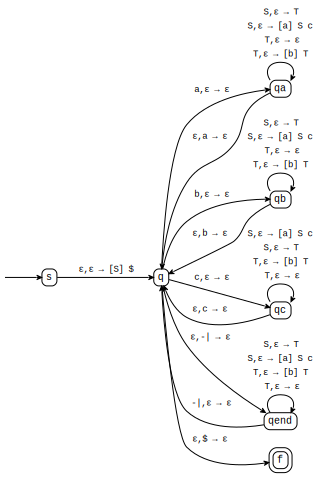

In [3]:
p2 = read_csv("llpda.csv")
to_graph(p2)

In [4]:
p2.is_deterministic()

False

This PDA is similar to the one in the proof of Lemma 2.21, but it has states $q_a$ that can apply rules with the knowledge that the next input symbol is $a$.

So, we can restrict the application of rules only to those that are allowed by Nullable, First, and Follow:

4. For each rule $A \rightarrow \beta$ and for each $c \in \Sigma$ such that $c \in \text{First}(\beta)$ or ($\text{Nullable}(\beta)$ and $c \in \text{Follow}(A)$), a transition from $q_c$ to itself that pops $A$ and pushes $\beta$.

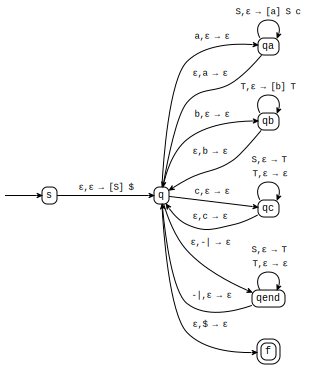

In [5]:
p3 = read_csv("lldpda.csv")
to_graph(p3)

In [6]:
p3.is_deterministic()

False

Now the PDA is deterministic, which is what we wanted. Note that it was _not_ guaranteed to be deterministic; we just got lucky. If it is deterministic, we say that the original grammar is $LL(1)$.

## Making grammars $LL(1)$

So, if grammars are not guaranteed to be $LL(1)$, how do we design our grammars so that they are? We show two strategies that can sometimes (but not always) help.

**Merge common prefixes.** Consider this very simple grammar:

\begin{align*}
S &\rightarrow \texttt{a b} \\
S &\rightarrow \texttt{a c}
\end{align*}

It's not $LL(1)$ because $\texttt{a}$ belongs to both $\text{First}(\texttt{a b})$ and $\text{First}(\texttt{a c})$. The solution is to create a new nonterminal for the non-shared part, like this:

\begin{align*}
S &\rightarrow \texttt{a} S' \\
S' &\rightarrow \texttt{b} \\
S' &\rightarrow \texttt{c}
\end{align*}

In general, if we have two rules 
\begin{align*}
A &\rightarrow \beta\gamma \\
A &\rightarrow \beta\delta
\end{align*}
then $\text{First}(\beta\gamma)$ and $\text{First}(\beta\delta)$ wlil overlap, and the solution is to change this to
\begin{align*}
A &\rightarrow \beta A' \\
A' &\rightarrow \gamma \\
A' &\rightarrow \delta
\end{align*}

**Eliminate left recursion.** Consider this grammar:

\begin{align*}
S &\rightarrow S~\texttt{-}~T \\
S &\rightarrow T \\
T &\rightarrow \texttt{1}
\end{align*}

The first rule is called _left-recursive_ because the first symbol on the right-hand side is the same as the left-hand side. In such cases there will always be an overlap between the left-recursive rule's and the "base case" rule's right-hand side. The usual fix is:

\begin{align*}
S &\rightarrow T S' \\
S' &\rightarrow \texttt{-}~T S' \\
S' &\rightarrow \varepsilon \\
T &\rightarrow \texttt{1}
\end{align*}

But be careful, because it seems we just changed - (minus) from left-associative to right-associative. In a recursive-descent parser, we can get the associativity correct like this:

```
function parse(w)
    val, i <- parseS(w, 0)
    if i = |w| then
        return val
    else
        error
        
function parseS(w, i)
    # S -> T S'
    val, i = parseT(w, i)
    val, i = parseS'(w, i, val)
    return val, i
    
function parseS'(w, i, val)
    # S' -> + T S'
    if i < |w| and w[i] in {"+"} # First(+ T S')
        i <- i + 1
        val2, i = parseT(w, i)
        val, i = parseS'(w, i, val-val2)
        return val, i
    else if i = |w| # Follow(S')
        return val, i
    else
        error
        
function parseT(w, i)
    # T -> a
    if i < |w| and w[i] in {"1"} # First(1)
        i <- i + 1
        return 1, i
    else
        error
```